In [1]:
import sys
sys.path.insert(0,'/server/home/klee/git/cmr_segment/')

import numpy as np
import h5py
import os
import ismrmrdtools
from ismrmrdtools import show,transform
from OCMR import read_ocmr as read
import pprint
import matplotlib.pyplot as plt
import math
import torch
from torchkbnufft import KbNufft, KbNufftAdjoint
from utils.dtype_conversions import r2c, c2r
from matplotlib import animation
from IPython import display
from sigpy import upsample

/server/home/klee/anaconda3/envs/cmr_segment/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rep_list(frames,a):
    orig = frames.copy()
    output = frames.copy()
    for j in range(a-1):
        output.extend(orig)

    return output

In [3]:
# Get lowfield scans from all OCMR scans

dir = '/server/sdata/klee/OCMR/OCMR_data/'
scans_all = np.array(os.listdir(dir))
# print(scans)
is_lowfield = ['0_55T' in mystring for mystring in scans_all]
scans_all = np.array(scans_all)
inds = np.where(is_lowfield)[0]
scans_lowfield = scans_all[inds]
print(scans_lowfield)
print(len(scans_lowfield))

['fs_0105_0_55T.h5' 'fs_0113_0_55T.h5' 'fs_0127_0_55T.h5'
 'fs_0146_0_55T.h5' 'fs_0120_0_55T.h5' 'fs_0152_0_55T.h5'
 'fs_0110_0_55T.h5' 'fs_0151_0_55T.h5' 'fs_0160_0_55T.h5'
 'fs_0150_0_55T.h5' 'fs_0108_0_55T.h5' 'fs_0124_0_55T.h5'
 'fs_0163_0_55T.h5' 'fs_0149_0_55T.h5' 'fs_0138_0_55T.h5'
 'fs_0112_0_55T.h5' 'fs_0135_0_55T.h5' 'fs_0133_0_55T.h5'
 'fs_0153_0_55T.h5' 'fs_0115_0_55T.h5' 'fs_0121_0_55T.h5'
 'fs_0141_0_55T.h5' 'fs_0134_0_55T.h5' 'fs_0117_0_55T.h5'
 'fs_0137_0_55T.h5' 'fs_0154_0_55T.h5' 'fs_0157_0_55T.h5'
 'fs_0158_0_55T.h5' 'fs_0116_0_55T.h5' 'fs_0126_0_55T.h5'
 'fs_0159_0_55T.h5' 'fs_0130_0_55T.h5' 'fs_0147_0_55T.h5'
 'fs_0129_0_55T.h5' 'fs_0107_0_55T.h5' 'fs_0128_0_55T.h5'
 'fs_0131_0_55T.h5' 'fs_0143_0_55T.h5' 'fs_0142_0_55T.h5'
 'fs_0125_0_55T.h5' 'fs_0109_0_55T.h5' 'fs_0164_0_55T.h5'
 'fs_0148_0_55T.h5' 'fs_0144_0_55T.h5' 'fs_0161_0_55T.h5'
 'fs_0145_0_55T.h5' 'fs_0106_0_55T.h5' 'fs_0118_0_55T.h5'
 'fs_0140_0_55T.h5' 'fs_0114_0_55T.h5' 'fs_0122_0_55T.h5'
 'fs_0162_0_55

In [4]:
# testing one scan
rand_num = np.random.randint(0,len(scans_lowfield))
filename = dir + scans_lowfield[10]
print(filename)
kData,param = read.read_ocmr(filename)

/server/sdata/klee/OCMR/OCMR_data/fs_0108_0_55T.h5
Imaging acquisition starts acq  0


In [5]:
print(param['FOV'])

[720.0, 300.0, 8.0]


In [6]:
voxel_size = [param['FOV'][0]/kData.shape[0],param['FOV'][1]/kData.shape[1]]
print(voxel_size)

[1.875, 2.2058823529411766]


In [7]:
# [kx, ky, kz, coil, phase, set, slice, rep, avg]
print('Dimension of kData: ', kData.shape)
print('Scan paramters:')
pprint.pprint(param)

# 2.08 mm x 2.94 mm

Dimension of kData:  (384, 136, 1, 15, 22, 1, 1, 1, 1)
Scan paramters:
{'FOV': [720.0, 300.0, 8.0],
 'TE': '[2.26]',
 'TI': '[300.0]',
 'TRes': '[36.080002]',
 'echo_spacing': '[4.51]',
 'flipAngle_deg': '[88.0]',
 'kspace_dim': {'kx ky kz coil phase set slice rep avg'},
 'sequence_type': 'SSFP'}


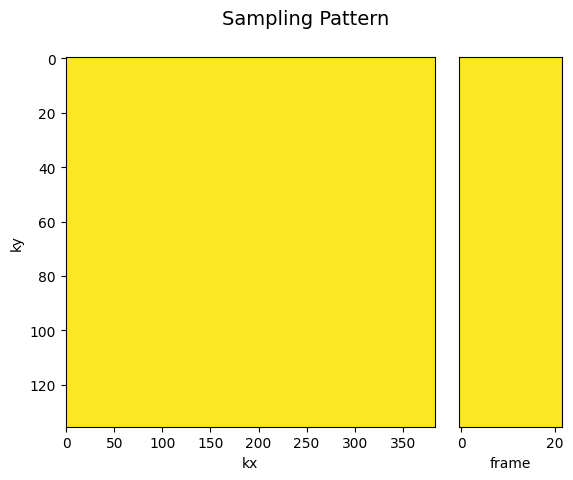

In [8]:
# Show the sampling Pattern
# kData_tmp-[kx,ky,kz,coil,phase,set,slice,rep], samp-[kx,ky,kz,phase,set,slice,rep]
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1
samp = (abs(np.mean(kData_tmp, axis = 3)) > 0).astype(np.int64) # kx ky kz phase set slice

slc_idx = math.floor(SLC/2);
fig1 = plt.figure(1); fig1.suptitle("Sampling Pattern", fontsize=14);
plt.subplot2grid((1, 8), (0, 0), colspan=6);
tmp = plt.imshow(np.transpose(np.squeeze(samp[:,:,0,0,0,slc_idx])), aspect= 'auto');
plt.xlabel('kx');plt.ylabel('ky'); tmp.set_clim(0.0,1.0) # ky by kx
plt.subplot2grid((1, 9), (0, 7),colspan=2);
tmp = plt.imshow(np.squeeze(samp[int(dim_kData[0]/2),:,0,:,0,slc_idx]),aspect= 'auto'); 
plt.xlabel('frame');plt.yticks([]); tmp.set_clim(0.0, 1.0) # ky by frame

In [9]:
SLC/2

0.5

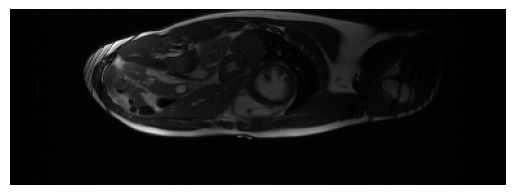

In [10]:
# Average the k-space along phase(time) dimension
kData_sl = kData_tmp[:,:,:,:,:,:,slc_idx,0];
samp_avg =  np.repeat(np.sum(samp[:,:,:,:,:,slc_idx,0],3), CH, axis=3) + np.finfo(float).eps
kData_sl_avg = np.divide(np.squeeze(np.sum(kData_sl,4)), np.squeeze(samp_avg));

im_avg = transform.transform_kspace_to_image(kData_sl_avg, [0,1]); # IFFT (2D image)
im = np.sqrt(np.sum(np.abs(im_avg) ** 2, 2)) # Sum of Square
fig2 = plt.figure(1); plt.imshow(np.transpose(im), vmin=0, vmax=0.8*np.amax(im), cmap = 'gray'); plt.axis('off'); # Show the image

In [11]:
# Image reconstruction (SoS)
dim_kData = kData.shape; CH = dim_kData[3]; SLC = dim_kData[6]; 
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1

im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
print(im_coil.shape)
im_sos = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)); # Sum of Square
print(im_sos.shape)
print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
RO = im_sos.shape[0];
image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:]; # Remove RO oversampling
print('Dimension of Image (without ReadOout ovesampling): ', image.shape)

(384, 136, 1, 15, 22, 1, 1, 1)
(384, 136, 1, 22, 1, 1, 1)
Dimension of Image (with ReadOut ovesampling):  (384, 136, 1, 22, 1, 1, 1)
Dimension of Image (without ReadOout ovesampling):  (192, 136, 1, 22, 1, 1, 1)


In [12]:
# Show the reconstructed cine image (central slice)
# from IPython.display import clear_output
# import time

# slc_idx = math.floor(SLC/2);
# print(slc_idx)
# image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx]);
# for rep in range(5): # repeate the movie for 5 times
#     for frame in range(image_slc.shape[2]):
#       clear_output(wait=True)
#       plt.imshow(image_slc[:,:,frame].T, vmin=0, vmax=0.6*np.amax(image_slc), cmap = 'gray'); plt.axis('off');
#       plt.show() 
#       time.sleep(0.03)

In [13]:
# image_slc.shape

In [14]:
# Loading all spiral arms

dir2 = '/server/sdata/klee/Speech/sub001/sub001_2drt_01_vcv1_r1/'

# Get 13 arms of k-space
k_loc_list = []
for iii in range(0,7):
    file_data = h5py.File(dir2+'frame{:05}.h5'.format(iii+1))
    # k_space = file_data['k_space'][:]
    k_loc_temp = file_data['k_loc'][:]
    k_loc_list.append(k_loc_temp)

k_loc = np.vstack(k_loc_list)
dcf = file_data['dcf'][:].squeeze()
# spoke_index = file_data['spoke_index'][:].astype(int)
# gt = file_data['gt'][:]

print(k_loc.shape)

(14, 630, 2)


(13, 630, 2)


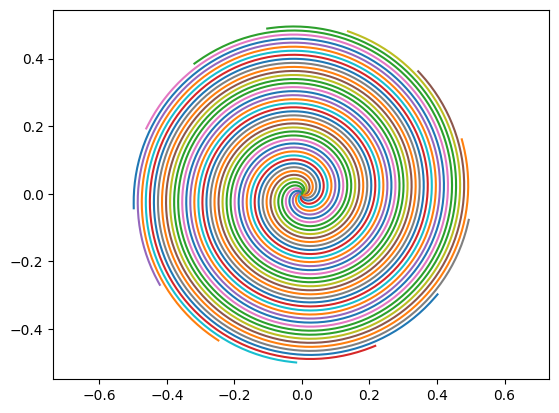

In [15]:
k_loc.shape
k_loc = k_loc[:13,:,:]
print(k_loc.shape)
plt.figure()
for i in range(0,13):
    plt.plot(k_loc[i, :, 0], k_loc[i, :, 1])
    plt.axis('equal')

# (13, 630, 2)

(-0.5181726202368736,
 0.4452469632029533,
 -0.5230062991380692,
 0.4810927301645279)

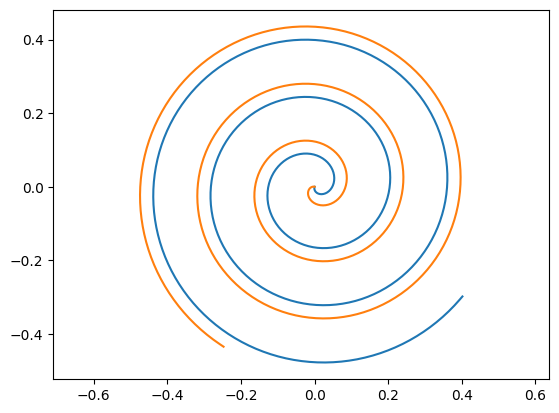

In [16]:
plt.figure()
plt.plot(k_loc[0,:,0],k_loc[0,:,1])
plt.plot(k_loc[1,:,0],k_loc[1,:,1])
plt.axis('equal')


In [17]:
dcf.shape

(630,)

In [18]:
FOV = param['FOV']
delta_x_cart = FOV[0]/kData.shape[0]
delta_y_cart = FOV[1]/kData.shape[0]
print(delta_x_cart)
print(delta_y_cart)

delta_x_spiral = 200/84
print(delta_x_spiral)

1.875
0.78125
2.380952380952381


(384, 136, 1, 15, 1, 1, 1, 1)
(384, 136, 15)
(15, 384, 136)


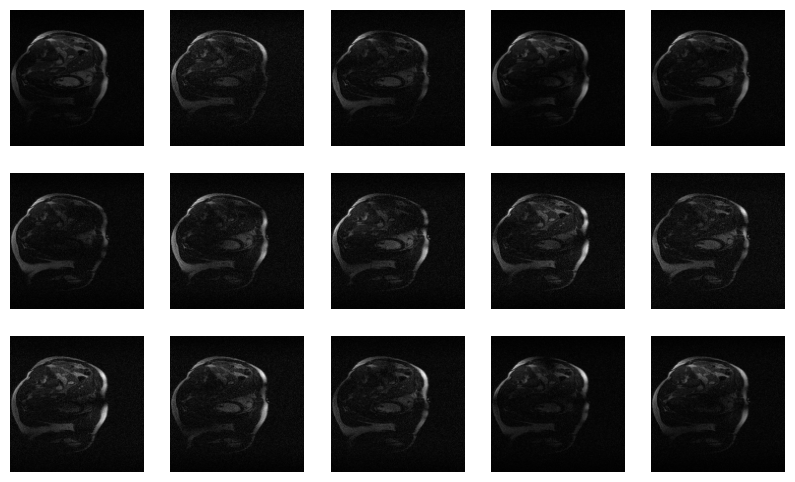

In [19]:

kData2 = kData[:,:,:,:,0,:,:,:]#np.mean(kData,axis=3)

image = transform.transform_kspace_to_image(kData2)
print(image.shape)

image2 = np.squeeze(image)
print(image2.shape)
image2 = np.transpose(image2,(2,0,1))
print(image2.shape)

nrows = 3
ncols = 5
plt.figure(figsize=(10,6))

i = 0
while(i < nrows*ncols) and (i < image2.shape[0]):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(np.abs(image2[i,:,:]),cmap='gray')
    plt.axis('tight')
    plt.axis('off')

    i+=1
plt.show()

In [20]:
image3 = upsample(image2,oshape=(image2.shape[0],2*image2.shape[1],2*image2.shape[2]),factors=(1,2,2))

In [21]:
# print(k_space.shape)
print(k_loc.shape[0])
print(k_loc.shape[1])
image_complex = torch.tensor(image2).unsqueeze(0)
print(image_complex.shape)


13
630
torch.Size([1, 15, 384, 136])


In [22]:
k_loc.shape

(13, 630, 2)

In [23]:
k_loc_torch = torch.tensor(k_loc)
k_loc_torch = torch.permute(k_loc_torch, [2, 0, 1])
k_loc_torch = torch.reshape(k_loc_torch,(2,-1))
print(k_loc_torch.shape)
# k_loc_torch = torch.permute(k_loc_torch,(0,2,1))
# print(k_loc_torch.size())
# k_loc_torch = k_loc_torch.reshape(*k_loc_torch.shape[:1],-1)
# print(k_loc_torch.size())

# plt.figure()
# plt.plot(k_loc_torch[0,:],k_loc_torch[1,:],'.')
# plt.axis('equal')
# plt.show()

# print(k_loc_torch.shape)

dcf_rep = rep_list(dcf.tolist(),13)

dcf_torch = torch.tensor(dcf_rep)
# dcf_torch = torch.hstack([dcf_torch,dcf_torch])
print(dcf_torch.shape)


torch.Size([2, 8190])
torch.Size([8190])


In [24]:
nufft_obj = KbNufft(im_size=(image_complex.shape[2],image_complex.shape[3]))
k_space = nufft_obj(image_complex,k_loc_torch)
print(k_space.shape)

# scale k_loc to go from -pi to pi.
k_loc_torch = (k_loc_torch / torch.max(torch.abs(k_loc_torch[0,:] + 1j * k_loc_torch[1,:]))) * np.pi/2

# nufft_adj_obj = KbNufftAdjoint(im_size=(kData.shape[0],kData.shape[1]))
nufft_adj_obj = KbNufftAdjoint(im_size=(image_complex.shape[2],image_complex.shape[3]))
ims_spiral = nufft_adj_obj(k_space*dcf_torch,k_loc_torch)

torch.Size([1, 15, 8190])


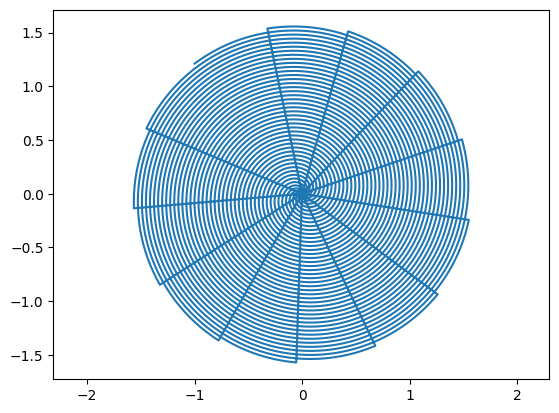

In [25]:
plt.plot(k_loc_torch[0,:],k_loc_torch[1,:])
plt.axis('equal')
plt.show()

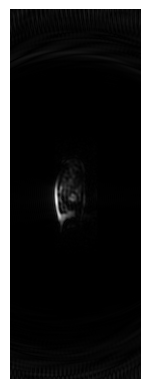

In [26]:
# ims_spiral_sos = torch.sqrt(torch.sum(torch.abs(ims_spiral)**2,dim=1)).squeeze()
ims_spiral_sos = torch.mean(ims_spiral,dim=1).squeeze()

plt.figure()
plt.imshow(torch.abs(ims_spiral_sos),cmap='gray')
plt.axis('off')
plt.show()

In [27]:
# Putting it all together

ims = transform.transform_kspace_to_image(kData,[0,1])
ims2 = np.squeeze(ims)

frames = []
for i in range(ims2.shape[2]):
    temp = np.transpose(ims2[:,:,:,i],(2,0,1))
    # temp1 = upsample(temp,oshape=(temp.shape[0],2*temp.shape[1],2*temp.shape[2]),factors=(1,2,2))
    temp_complex = torch.tensor(temp).unsqueeze(0)
    k_space_temp = nufft_obj(temp_complex,k_loc_torch)
    k_space_temp = k_space_temp * dcf_torch
    temp_spiral = nufft_adj_obj(k_space_temp,k_loc_torch)
    temp_spiral_sos = torch.mean(torch.sqrt(torch.abs(temp_spiral)**2),dim=1).squeeze()
    # temp_spiral_sos = torch.mean(temp_spiral,dim=1).squeeze()
    
    frames.append(temp_spiral_sos)


In [28]:

print(len(frames))
frames1 = rep_list(frames,3)

15


In [29]:
# spiral-synthesized cine
fig, ax = plt.subplots()

def animate_func(num):
    ax.clear()
    ax.imshow(torch.abs(frames1[num]),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

ani = animation.FuncAnimation(fig, animate_func, interval=100,frames=len(frames1),repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [30]:
ims.shape
ims[:,:,:,:,0,:,:,:].shape

(384, 136, 1, 15, 1, 1, 1, 1)

In [31]:
frames2 = []
for ii in range(ims.shape[4]):
    tmp_sos = np.sqrt( np.mean(np.abs( np.squeeze(ims[:,:,:,:,ii,:,:,:]) )**2,axis=2))
    frames2.append(tmp_sos)

frames2 = rep_list(frames2,3)
print(len(frames2))

66


In [32]:
# original cine
fig, ax = plt.subplots()

def animate_func(num):
    ax.clear()
    ax.imshow(frames2[num],cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

ani = animation.FuncAnimation(fig, animate_func, interval=100,frames=len(frames2),repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

(66, 384, 136)


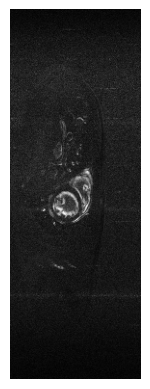

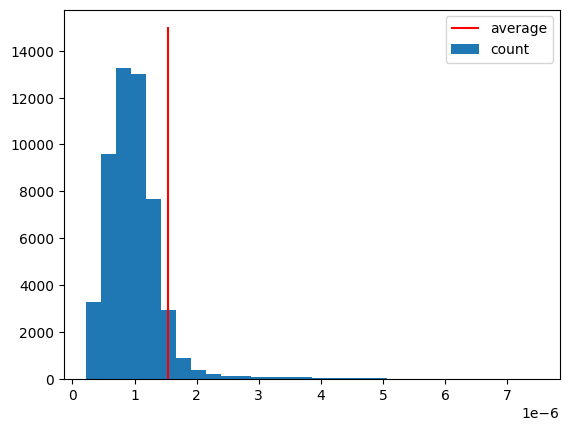

In [33]:
# extra stuff, non synthesis related

gt_array = np.array(frames2)
print(gt_array.shape)

gt_std = np.std(gt_array,axis=0)

plt.figure()
plt.imshow(gt_std,cmap='gray')
plt.axis('off')
plt.show()

thresh = np.mean(gt_std.flatten()) + 1 * np.std(gt_std.flatten())

plt.figure()
plt.hist(gt_std.flatten(),bins=30)
plt.vlines(x=thresh,ymin=0,ymax=15000,colors='red')
plt.legend(['average','count'])
plt.show()

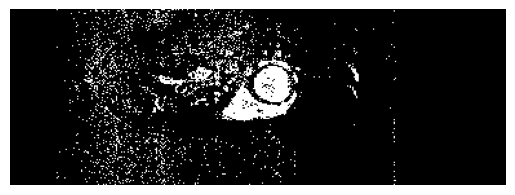

In [34]:
bw = np.copy(gt_std)
bw[gt_std >= thresh] = 1
bw[gt_std < thresh] = 0

plt.figure()
plt.imshow(bw.T,cmap='gray')
plt.axis('off')
plt.show()